In [1]:
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet50, vgg16

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_from_disk

/home/thesis/anaconda3/envs/sg-diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparams

In [2]:
CNN = 'ResNet-50' # 'ResNet-50' or 'VGG-16'
#DATASET = 'CelebA_male_Smiling'
DATASET = 'CelebA_drift_simulated_with_Male_Wearing_Earrings'

NUM_CLASSES = 1      # Gender classification (1 for binary classification)

BATCH_SIZE = 256

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD
WEIGHT_DECAY = 0.0   # Regularization 1e-5 1e-8

NUM_EPOCHS = 15      # Total number of training epochs
STEP_SIZE = 5       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 100

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset

In [3]:
dataset = load_from_disk(f"data/CelebA/{DATASET}")

num_train = dataset["historical_train"].num_rows
num_validation = dataset["historical_test"].num_rows
num_test = dataset["datastream_no_drift"].num_rows
num_test_drift = dataset["datastream_drift"].num_rows

In [4]:
print("Train split (historical_train):{}, \n"
      "Validation split (historical_test):{}, \n"
      "Test split (datastream_no_drift):{}, \n"
      "Test split (datastream_drift):{}".format(num_train, num_validation, num_test, num_test_drift))

Train split (historical_train):155951, 
Validation split (historical_test):19114, 
Test split (datastream_no_drift):19076, 
Test split (datastream_drift):1349


In [5]:
dataset

DatasetDict({
    historical_train: Dataset({
        features: ['image_id', 'is_drift', 'image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
        num_rows: 155951
    })
    historical_test: Dataset({
        features: ['image_id', 'is_drift', 'image', 'celeb_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebro

In [6]:
from datasets import Value

class HFDatasetWrapper_concepts(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset_img = hf_dataset.select_columns(['image'])
        self.transform = transform
        self.columns = [attr for attr in hf_dataset.features if attr not in ['image', 'celeb_id', 'image_id', 'is_drift', 'Male']]
        self.dataset_labels = hf_dataset.select_columns(self.columns)

        # cast to float
        for col in self.dataset_labels.column_names:
            if self.dataset_labels.features[col].dtype == "bool":
                self.dataset_labels = self.dataset_labels.cast_column(col, Value(dtype="float"))

    def __len__(self):
        return len(self.dataset_img)

    def __getitem__(self, idx):
        item = self.dataset_img[idx]
        #image = Image.open(BytesIO(item['image']))
        #image = Image.open(item['image'])
        image = item['image']
        label = torch.tensor(list(self.dataset_labels[idx].values()))
        #print(type(image))

        if self.transform:
            image = self.transform(image)

        return image, label

### Data processing

In [7]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(224),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image 224
                                      transforms.ToTensor(),       # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with ImageNet mean and standard deviation
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Data Loaders

In [8]:
# Datasets
train_dataset = HFDatasetWrapper_concepts(dataset['historical_train'], transform=train_transform)
val_dataset = HFDatasetWrapper_concepts(dataset['historical_test'], transform=eval_transform)
test_dataset = HFDatasetWrapper_concepts(dataset['datastream_no_drift'], transform=eval_transform)
test_dataset_drift = HFDatasetWrapper_concepts(dataset['datastream_drift'], transform=eval_transform)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader_drift = DataLoader(test_dataset_drift, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

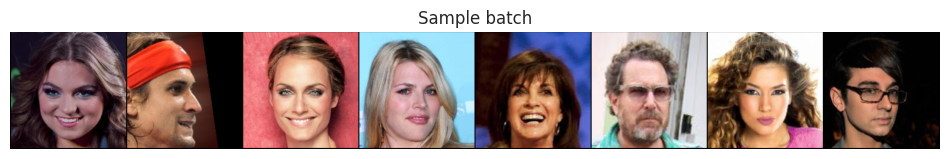

In [9]:
images, labels = next(iter(train_dataloader))

imgs = images[:8] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=True, value_range=(0, 1))

plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.show()

### Model

In [10]:
net = resnet50() # Loading ResNet-50 model (pretrained on ImageNet)
net.fc = nn.Linear(2048, NUM_CLASSES) # Changed the last layer of ResNet-50
#net.avgpool = nn.AdaptiveMaxPool2d((1,1))

# Load pre-trained net
net.load_state_dict(torch.load(f'./weights/{CNN}-{DATASET}.pth', weights_only=True))
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
encoder = torch.nn.Sequential(*list(net.children())[:-1]).to(DEVICE)
encoder

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [12]:
# Check encoder output shape
x = torch.randn(1,3,224,224).to(DEVICE)

with torch.no_grad():
    y = encoder(x).squeeze()

y.shape

torch.Size([2048])

In [13]:
#concept_head = nn.Linear(2048, 39)

concept_head = nn.Sequential(
    nn.Linear(2048, 2048),
    nn.GELU(),
    nn.Linear(2048, 39),
)

### Training

In [14]:
# Compute label weights for loss
columns = [attr for attr in dataset['historical_train'].features if attr not in ['image', 'celeb_id', 'image_id', 'is_drift', 'Male']]
t_labels = dataset['historical_train'].select_columns(columns)

# cast to float
for col in t_labels.column_names:
    if t_labels.features[col].dtype == "bool":
        t_labels = t_labels.cast_column(col, Value(dtype="float"))

tensor_labels = torch.stack([torch.tensor(t_labels[col]) for col in columns], dim=1)

pos_counts = tensor_labels.sum(dim=0)
neg_counts = tensor_labels.size(0) - pos_counts
label_weights = neg_counts / pos_counts
label_weights = label_weights.to(DEVICE)
label_weights

tensor([ 8.1876,  2.6945,  0.8960,  3.9828, 47.3419,  5.4820,  3.2950,  3.5011,
         3.3027,  5.4877, 18.5697,  3.7681,  6.1100, 17.9883, 21.4973, 15.3180,
        16.9275, 22.0492,  1.5087,  1.1921,  1.0745, 27.1856,  7.6285,  0.1797,
         2.4986, 21.8869,  2.5325, 12.0601, 13.8638, 17.2122,  1.0668,  3.7262,
         2.0473,  4.3931, 21.3907,  1.0557,  7.1305, 12.7961,  0.2806],
       device='cuda:0')

In [15]:
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights)
criterion = nn.BCEWithLogitsLoss()

#parameters_to_optimize = net.features.parameters()
#parameters_to_optimize = net.classifier.parameters()
parameters_to_optimize = concept_head.parameters()

#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = optim.AdamW(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [16]:
def plot_loss_accuracy_trend(loss_values, accuracy_values):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)

    epochs = np.arange(1, NUM_EPOCHS+1)

    plt.plot(epochs, loss_values[0], label="Training")
    plt.plot(epochs, loss_values[1], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs, accuracy_values[0], label="Training")
    plt.plot(epochs, accuracy_values[1], label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def get_accuracy(encoder, concept_head, dataLoader):
    encoder = encoder.to(DEVICE)
    concept_head = concept_head.to(DEVICE)
    encoder.eval()
    concept_head.eval()

    with torch.no_grad():
        running_corrects = 0
        for images, labels in dataLoader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = concept_head(encoder(images).squeeze())
            # Get predictions
            #_, preds = torch.max(outputs.data, 1) # multi-class classification
            preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item() / 39.

    # Calculate and return Accuracy
    return running_corrects / (float(len(dataLoader.dataset)) - (len(train_dataloader.dataset) % BATCH_SIZE))

Starting epoch 1/15, LR = [0.001]
Step 0, Loss 0.6996819972991943
Step 100, Loss 0.36791306734085083
Step 200, Loss 0.3353036046028137
Step 300, Loss 0.3382031321525574
Step 400, Loss 0.34468522667884827
Step 500, Loss 0.3414649963378906
Step 600, Loss 0.3247530162334442
Test Accuracy on Validation: 0.8513789060508743
Starting epoch 2/15, LR = [0.001]
Step 700, Loss 0.3184361159801483
Step 800, Loss 0.3135683536529541
Step 900, Loss 0.3176276981830597
Step 1000, Loss 0.3139801025390625
Step 1100, Loss 0.3000927269458771
Step 1200, Loss 0.31149232387542725
Test Accuracy on Validation: 0.8586041108276118
Starting epoch 3/15, LR = [0.001]
Step 1300, Loss 0.3019323945045471
Step 1400, Loss 0.31551289558410645
Step 1500, Loss 0.29482656717300415
Step 1600, Loss 0.31438395380973816
Step 1700, Loss 0.30960744619369507
Step 1800, Loss 0.30661338567733765
Test Accuracy on Validation: 0.8618343917601008
Starting epoch 4/15, LR = [0.001]
Step 1900, Loss 0.29964593052864075
Step 2000, Loss 0.29230

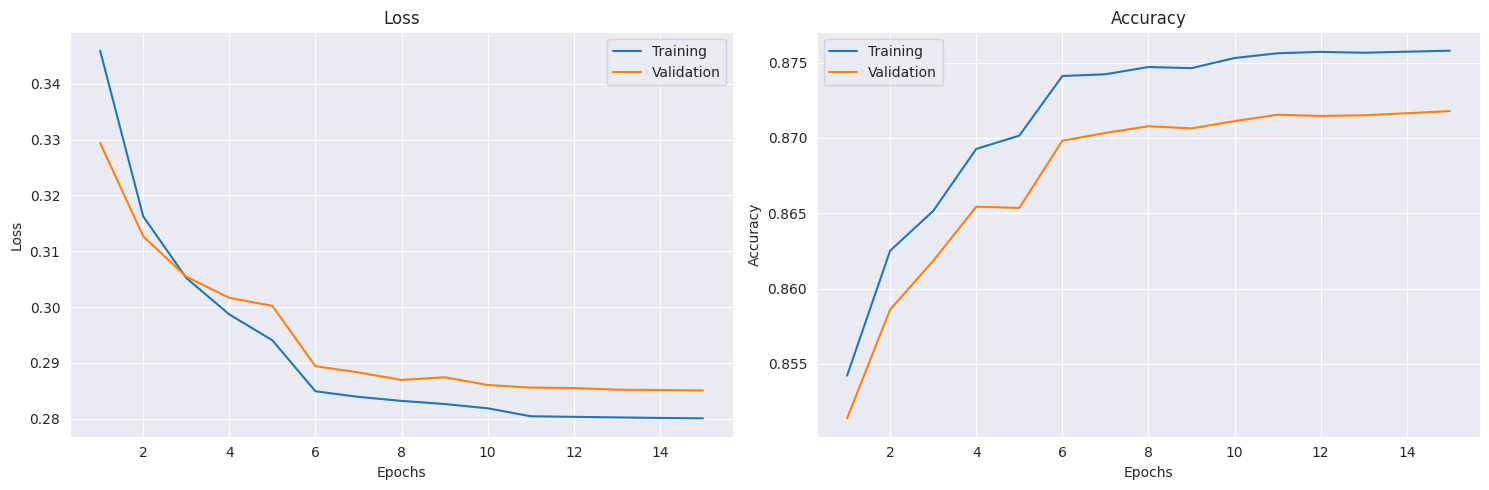

In [17]:
encoder = encoder.to(DEVICE)
concept_head = concept_head.to(DEVICE)

encoder.eval()

best_net = None
best_accuracy = 0.0

train_acc = []
val_acc = []
train_loss = []
val_loss = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    running_loss = 0.0
    # Iterate over the dataset
    for images, labels in train_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        concept_head.train() # Sets module in training mode

        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        with torch.no_grad():
            features = encoder(images).squeeze()

        outputs = concept_head(features)

        # Compute loss based on output and ground truth
        loss = criterion(outputs.squeeze(1), labels)
        running_loss += loss.item()

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

    train_loss.append(running_loss / float(len(train_dataloader)))  # compute average loss
    train_acc.append(get_accuracy(encoder, concept_head, train_dataloader)) # compute accuracy on train set

    # Evaluate the model on the validation set
    encoder = encoder.to(DEVICE)
    concept_head = concept_head.to(DEVICE)
    encoder.eval() # Set Network to evaluation mode
    concept_head.eval()

    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        for images, labels in val_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = concept_head(encoder(images).squeeze())

            # Compute loss based on output and ground truth
            loss = criterion(outputs.squeeze(1), labels)
            running_loss += loss.item()

            # Get predictions
            #_, preds = torch.max(outputs.data, 1) # multi-class classification
            preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item() / 39.

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    print('Test Accuracy on Validation: {}'.format(accuracy))

    # Update the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_net = copy.deepcopy(concept_head)

    val_acc.append(accuracy)
    val_loss.append(running_loss / float(len(val_dataloader)))

    # Step the scheduler
    scheduler.step()

# Plot loss and accuracy trend
plot_loss_accuracy_trend([train_loss, val_loss], [train_acc, val_acc])

### Test (train set)

In [18]:
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, MultilabelAUROC

best_net = concept_head.to(DEVICE) #best_net.to(DEVICE)
best_net.eval() # Set Network to evaluation mode

ml_acc = MultilabelAccuracy(num_labels=39, average=None).to(DEVICE)
ml_f1 = MultilabelF1Score(num_labels=39, average=None).to(DEVICE)
ml_auroc = MultilabelAUROC(num_labels=39, average=None).to(DEVICE)

with torch.no_grad():
    running_corrects = 0
    for images, labels in tqdm(train_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = best_net(encoder(images).squeeze())

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item() / 39.

        ml_acc.update(preds, labels.data)
        ml_f1.update(preds, labels.data)
        ml_auroc.update(outputs, labels.data.int())

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset_drift))

print('Test Accuracy: {}'.format(accuracy))
#print('Best Accuracy on Validation: {}'.format(best_accuracy))

print("|------ TORCHMETRICS ------|")
print('Test Accuracy: {}'.format(ml_acc.compute().mean().item()))
print('Test Accuracies: {}'.format(ml_acc.compute()))
print('Test F1 score: {}'.format(ml_f1.compute().mean().item()))
print('Test F1 scores: {}'.format(ml_f1.compute()))
print('Test AUROC score: {}'.format(ml_auroc.compute().mean()))
print('Test AUROC scores: {}'.format(ml_auroc.compute()))

100%|██████████| 609/609 [02:01<00:00,  5.01it/s]


Test Accuracy: 101.21586740415498
|------ TORCHMETRICS ------|
Test Accuracy: 0.8757966756820679
Test Accuracies: tensor([0.9061, 0.7926, 0.7684, 0.8126, 0.9795, 0.9022, 0.7673, 0.8050, 0.8553,
        0.9281, 0.9490, 0.8229, 0.8820, 0.9474, 0.9559, 0.9677, 0.9528, 0.9642,
        0.8781, 0.8163, 0.7612, 0.9650, 0.8841, 0.9124, 0.7381, 0.9579, 0.7277,
        0.9262, 0.9377, 0.9521, 0.8502, 0.7918, 0.7497, 0.8282, 0.9632, 0.9125,
        0.8769, 0.9315, 0.8362], device='cuda:0')
Test F1 score: 0.4398506283760071
Test F1 scores: tensor([4.4735e-01, 5.7561e-01, 7.8823e-01, 3.1472e-01, 2.1859e-01, 6.3373e-01,
        3.1323e-03, 4.0481e-01, 6.5624e-01, 7.5313e-01, 1.5350e-02, 4.5858e-01,
        3.9002e-01, 1.3321e-01, 1.6539e-01, 6.8684e-01, 4.2570e-01, 4.5511e-01,
        8.5368e-01, 7.9000e-01, 7.4161e-01, 2.0899e-01, 4.4267e-04, 9.4926e-01,
        3.2689e-01, 1.2014e-01, 3.0981e-01, 2.3403e-01, 3.5935e-01, 4.0320e-01,
        8.4157e-01, 9.4007e-02, 5.7625e-01, 3.6163e-01, 3.9853e-01

### Test (drift 0%)

In [19]:
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, MultilabelAUROC

best_net = concept_head.to(DEVICE) #best_net.to(DEVICE)
best_net.eval() # Set Network to evaluation mode

ml_acc = MultilabelAccuracy(num_labels=39, average=None).to(DEVICE)
ml_f1 = MultilabelF1Score(num_labels=39, average=None).to(DEVICE)
ml_auroc = MultilabelAUROC(num_labels=39, average=None).to(DEVICE)

with torch.no_grad():
    running_corrects = 0
    for images, labels in tqdm(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = best_net(encoder(images).squeeze())

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item() / 39.

        ml_acc.update(preds, labels.data)
        ml_f1.update(preds, labels.data)
        ml_auroc.update(outputs, labels.data.int())

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))
print('Best Accuracy on Validation: {}'.format(best_accuracy))

print("|------ TORCHMETRICS ------|")
print('Test Accuracy: {}'.format(ml_acc.compute().mean().item()))
print('Test Accuracies: {}'.format(ml_acc.compute()))
print('Test F1 score: {}'.format(ml_f1.compute().mean().item()))
print('Test F1 scores: {}'.format(ml_f1.compute()))
print('Test AUROC score: {}'.format(ml_auroc.compute().mean()))
print('Test AUROC scores: {}'.format(ml_auroc.compute()))

100%|██████████| 75/75 [00:15<00:00,  4.79it/s]


Test Accuracy: 0.87731798850482
Best Accuracy on Validation: 0.8717841399645313
|------ TORCHMETRICS ------|
Test Accuracy: 0.8773179650306702
Test Accuracies: tensor([0.9088, 0.7911, 0.7563, 0.8072, 0.9821, 0.9011, 0.8557, 0.7939, 0.8677,
        0.9213, 0.9529, 0.7955, 0.8937, 0.9458, 0.9547, 0.9662, 0.9477, 0.9565,
        0.8790, 0.8189, 0.7610, 0.9590, 0.9245, 0.9110, 0.7402, 0.9571, 0.7261,
        0.9345, 0.9330, 0.9426, 0.8466, 0.7984, 0.7629, 0.8309, 0.9640, 0.9000,
        0.8781, 0.9347, 0.8148], device='cuda:0')
Test F1 score: 0.43593481183052063
Test F1 scores: tensor([0.5115, 0.5722, 0.7802, 0.2976, 0.1896, 0.6209, 0.0022, 0.3843, 0.6561,
        0.7409, 0.0239, 0.4610, 0.4561, 0.1163, 0.1478, 0.6870, 0.3922, 0.3953,
        0.8570, 0.7931, 0.7415, 0.1537, 0.0000, 0.9479, 0.3224, 0.1107, 0.3321,
        0.2461, 0.3397, 0.3711, 0.8391, 0.1159, 0.5765, 0.3920, 0.3827, 0.8989,
        0.0000, 0.2602, 0.8857], device='cuda:0')
Test AUROC score: 0.8651185631752014
Test AUROC s

### Test (drift 100%)

In [20]:
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, MultilabelAUROC

best_net = concept_head.to(DEVICE) #best_net.to(DEVICE)
best_net.eval() # Set Network to evaluation mode

ml_acc = MultilabelAccuracy(num_labels=39, average=None).to(DEVICE)
ml_f1 = MultilabelF1Score(num_labels=39, average=None).to(DEVICE)
ml_auroc = MultilabelAUROC(num_labels=39, average=None).to(DEVICE)

with torch.no_grad():
    running_corrects = 0
    for images, labels in tqdm(test_dataloader_drift):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = best_net(encoder(images).squeeze())

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item() / 39.

        ml_acc.update(preds, labels.data)
        ml_f1.update(preds, labels.data)
        ml_auroc.update(outputs, labels.data.int())

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset_drift))

print('Test Accuracy: {}'.format(accuracy))
print('Best Accuracy on Validation: {}'.format(best_accuracy))

print("|------ TORCHMETRICS ------|")
print('Test Accuracy: {}'.format(ml_acc.compute().mean().item()))
print('Test Accuracies: {}'.format(ml_acc.compute()))
print('Test F1 score: {}'.format(ml_f1.compute().mean().item()))
print('Test F1 scores: {}'.format(ml_f1.compute()))
print('Test AUROC score: {}'.format(ml_auroc.compute().mean()))
print('Test AUROC scores: {}'.format(ml_auroc.compute()))

100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

Test Accuracy: 0.8114272680618121
Best Accuracy on Validation: 0.8717841399645313
|------ TORCHMETRICS ------|
Test Accuracy: 0.8114272952079773
Test Accuracies: tensor([0.8258, 0.7932, 0.8562, 0.7294, 0.9088, 0.9555, 0.4255, 0.5997, 0.6716,
        0.9830, 0.9770, 0.9577, 0.8021, 0.7302, 0.8725, 0.9036, 0.7635, 0.9844,
        0.9681, 0.7517, 0.7213, 0.7635, 0.8562, 0.6968, 0.6612, 0.9874, 0.9451,
        0.7613, 0.9993, 0.8762, 0.8043, 0.8955, 0.9259, 0.0015, 0.8525, 0.9555,
        0.8747, 0.9096, 0.6983], device='cuda:0')
Test F1 score: 0.27008822560310364
Test F1 scores: tensor([0.1392, 0.0071, 0.3899, 0.3470, 0.1854, 0.4643, 0.0026, 0.6386, 0.5105,
        0.2069, 0.0000, 0.2597, 0.4628, 0.1292, 0.0753, 0.7368, 0.4762, 0.0870,
        0.1224, 0.6640, 0.7291, 0.1402, 0.0000, 0.6950, 0.0256, 0.1053, 0.0000,
        0.0800, 0.0000, 0.2160, 0.7668, 0.1754, 0.1071, 0.0030, 0.5467, 0.1892,
        0.0000, 0.0469, 0.8023], device='cuda:0')
Test AUROC score: 0.7628911733627319
Test AUROC


/home/thesis/anaconda3/envs/sg-diff/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


In [21]:
images, labels = next(iter(test_dataloader))

encoder = encoder.to(DEVICE)
best_net = best_net.to(DEVICE)
encoder.eval()
best_net.eval()

img = images[1].unsqueeze(0).to(DEVICE)
print(img.shape)

outputs = best_net(encoder(img).squeeze())
print(outputs.shape)
preds = torch.sigmoid(outputs) >= 0.5

print(preds)
print(labels[1])
print(labels[1] == preds.cpu())

torch.Size([1, 3, 224, 224])
torch.Size([39])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False],
       device='cuda:0')
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1.])
tensor([False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False])


### Find optimal thresholds

In [22]:
# Find optimal thresholds

best_net = concept_head.to(DEVICE) #best_net.to(DEVICE)
best_net.eval() # Set Network to evaluation mode

ml_f1 = MultilabelF1Score(num_labels=39, average=None).to(DEVICE)

all_probs = []
all_labels = []

with torch.no_grad():
    running_corrects = 0
    for images, labels in tqdm(train_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = best_net(encoder(images).squeeze())

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1))

        all_probs.append(preds.cpu())
        all_labels.append(labels.cpu())

        #ml_f1.update(preds, labels.data)

probs = torch.cat(all_probs).numpy()
labels = torch.cat(all_labels).numpy()

#print('Test F1 score: {}'.format(ml_f1.compute().mean().item()))
#print('Test F1 scores: {}'.format(ml_f1.compute()))


100%|██████████| 609/609 [02:00<00:00,  5.05it/s]


In [23]:
from torchmetrics.functional.classification import binary_f1_score, binary_accuracy

optimal_thresholds = []
thresholds = np.arange(0.05, 0.95, 0.005)

num_classes = labels.shape[1]

#f1score = BinaryF1Score().to(DEVICE)

for c in range(num_classes):
    best_thresh = 0.5
    best_f1 = 0.0

    for t in thresholds:
        #preds = torch.tensor((probs[:, c] >= t).astype(int)).unsqueeze(1).to(DEVICE)
        preds = torch.tensor((probs[:, c])).unsqueeze(1).to(DEVICE)

        #print(torch.tensor(labels[:, c]).unsqueeze(1).shape)
        #print(preds.shape)
        #f1 = f1score(torch.tensor(labels[:, c]).unsqueeze(1).to(DEVICE), preds)
        #f1 = binary_f1_score(preds, torch.tensor(labels[:, c]).unsqueeze(1).to(DEVICE), threshold=t)
        f1 = binary_accuracy(preds, torch.tensor(labels[:, c]).unsqueeze(1).to(DEVICE), threshold=t)

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    optimal_thresholds.append(best_thresh)

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

tensor([0.4950, 0.4800, 0.5150, 0.4800, 0.5650, 0.5050, 0.4650, 0.4850, 0.4600,
        0.5000, 0.5000, 0.4950, 0.4550, 0.6100, 0.5600, 0.4400, 0.4750, 0.4600,
        0.5250, 0.5400, 0.5200, 0.5550, 0.4100, 0.4650, 0.4900, 0.4300, 0.5250,
        0.4750, 0.5550, 0.4550, 0.5100, 0.4600, 0.5150, 0.4950, 0.3700, 0.4800,
        0.5850, 0.5100, 0.5150], dtype=torch.float64)

In [24]:
encoder = encoder.to(DEVICE)
best_net = best_net.to(DEVICE)
encoder.eval()
best_net.eval()

img = images[1].unsqueeze(0).to(DEVICE)
print(img.shape)

outputs = best_net(encoder(img).squeeze())
print(outputs.shape)
preds = torch.sigmoid(outputs) >= optimal_thresholds.to(DEVICE)

print(preds)
print(labels[1])
print(labels[1] == preds.cpu())

torch.Size([1, 3, 224, 224])
torch.Size([39])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True],
       device='cuda:0')
[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.]
tensor([ True,  True, False,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True,  True,  True, False, False,  True,  True])


In [25]:
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, MultilabelAUROC

best_net = concept_head.to(DEVICE) #best_net.to(DEVICE)
best_net.eval() # Set Network to evaluation mode

ml_acc = MultilabelAccuracy(num_labels=39, average=None).to(DEVICE)
ml_f1 = MultilabelF1Score(num_labels=39, average=None).to(DEVICE)
ml_auroc = MultilabelAUROC(num_labels=39, average=None).to(DEVICE)

with torch.no_grad():
    running_corrects = 0
    for images, labels in tqdm(test_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = best_net(encoder(images).squeeze())

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1)) >= optimal_thresholds.to(DEVICE) # binary classification

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item() / 39.

        ml_acc.update(preds, labels.data)
        ml_f1.update(preds, labels.data)
        ml_auroc.update(outputs, labels.data.int())

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))
print('Best Accuracy on Validation: {}'.format(best_accuracy))

print("|------ TORCHMETRICS ------|")
print('Test Accuracy: {}'.format(ml_acc.compute().mean().item()))
print('Test Accuracies: {}'.format(ml_acc.compute()))
print('Test F1 score: {}'.format(ml_f1.compute().mean().item()))
print('Test F1 scores: {}'.format(ml_f1.compute()))
print('Test AUROC score: {}'.format(ml_auroc.compute().mean()))
print('Test AUROC scores: {}'.format(ml_auroc.compute()))

100%|██████████| 75/75 [00:15<00:00,  4.85it/s]


Test Accuracy: 0.8775169228618589
Best Accuracy on Validation: 0.8717841399645313
|------ TORCHMETRICS ------|
Test Accuracy: 0.8775169253349304
Test Accuracies: tensor([0.9091, 0.7918, 0.7575, 0.8077, 0.9830, 0.9014, 0.8556, 0.7956, 0.8667,
        0.9213, 0.9529, 0.7948, 0.8951, 0.9458, 0.9544, 0.9660, 0.9477, 0.9571,
        0.8800, 0.8185, 0.7617, 0.9593, 0.9244, 0.9103, 0.7394, 0.9578, 0.7224,
        0.9338, 0.9340, 0.9441, 0.8468, 0.7990, 0.7658, 0.8316, 0.9647, 0.8985,
        0.8781, 0.9348, 0.8148], device='cuda:0')
Test F1 score: 0.44047918915748596
Test F1 scores: tensor([0.5173, 0.5897, 0.7787, 0.3307, 0.1645, 0.6196, 0.0213, 0.4068, 0.6682,
        0.7409, 0.0239, 0.4623, 0.4969, 0.0426, 0.0975, 0.6972, 0.4104, 0.4280,
        0.8566, 0.7868, 0.7367, 0.1162, 0.0028, 0.9478, 0.3344, 0.1727, 0.2620,
        0.2661, 0.2875, 0.4238, 0.8385, 0.1621, 0.5681, 0.4019, 0.4874, 0.8978,
        0.0000, 0.2480, 0.8852], device='cuda:0')
Test AUROC score: 0.8651185631752014
Test AUROC

### Save model

In [26]:
os.makedirs('./weights', exist_ok=True)
torch.save(best_net.state_dict(), f'./weights/{CNN}-concept_head-{DATASET}.pth')

In [27]:
#concept_head.load_state_dict(torch.load(f'./weights/{CNN}-concept_head-{DATASET}.pth', weights_only=True))
#best_net = concept_head.to(DEVICE)